In [121]:
import pandas as pd
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/source/df_joined.csv')
df['default'] = df['default'].astype('int')
df['obs_date'] = pd.to_datetime(df['obs_date'])
df['year'] = df['obs_date'].dt.year

In [ ]:
df

In [46]:
df_slice = df[df['ID']==1574]
df_slice2 = df[df['ID']==9353]

,ID,obs_date,Var_01,Var_02,Var_03,Var_04,Var_05,Var_06,Var_07,Var_08,...,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,default,year
53937,1574,2015-12-31,145981.431332,2.084565e+06,121857.381239,1.340909,0.314156,618.565387,0.766667,170105.481425,...,598152.729228,2.167220,1.177748e+06,0.435015,598152.729228,3.503623,2474.261548,37113.923220,0,2015
53935,1574,2016-12-31,243055.764800,2.667237e+06,128323.855871,1.775559,0.328272,411.619273,0.760961,207691.324722,...,681489.093546,2.533756,1.606237e+06,0.397790,681489.093546,3.274769,13132.357001,106166.049956,0,2016
53934,1574,2017-12-31,113377.298128,2.470817e+06,95445.639441,1.081923,0.191255,1513.054904,1.000000,236928.021420,...,446638.143183,1.333738,1.662793e+06,0.327027,446638.143183,1.873159,10926.036474,8584.895521,0,2017
53933,1574,2018-12-31,197060.429613,3.136429e+06,156790.021348,2.051041,0.175084,3074.958899,0.730127,218898.858812,...,438431.372449,1.755347,2.225452e+06,0.290450,438431.372449,1.975149,1578.360406,100982.183478,0,2018
53936,1574,2019-12-31,176625.968128,2.413088e+06,154848.635273,1.096836,0.180196,2177.674556,0.652214,127950.713298,...,478563.364371,2.159835,1.559727e+06,0.353639,478563.364371,3.677625,1799.459234,15593.747255,0,2019


In [47]:
filter_df(df_slice2)

C:\Users\micha\AppData\Local\Temp\ipykernel_7552\3190752475.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=['ID', 'obs_date'], inplace=True)


,ID,obs_date,Var_01,Var_02,Var_03,Var_04,Var_05,Var_06,Var_07,Var_08,...,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,default,year
0,9353,2015-03-31,2.586283e+09,1.063976e+10,4.099697e+07,0.814620,0.547254,1.038821e+09,0.352002,2.454954e+09,...,3.011540e+09,0.598954,2.348640e+09,0.640609,3.011540e+09,0.861973,9.297278e+08,-5.885497e+08,0,2015
1,9353,2016-03-31,3.068856e+09,1.282924e+10,4.147103e+07,0.744966,0.785927,1.297698e+09,0.354587,3.170806e+09,...,3.897413e+09,0.753560,2.729312e+09,0.666038,3.897413e+09,0.872196,1.389280e+09,-1.050599e+09,1,2016


In [44]:
def filter_df(df):
    # Group by ID and sum the default column
    default_sums = df.groupby('ID')['default'].sum()

    # Filter in only values where the sum is less than 1 (meaning no occurrence of default = 1)
    no_default_indices = df[df['ID'].isin(default_sums[default_sums < 1].index)]
    no_default_indices['filter_condition'] = True
    # Sort the DataFrame by 'ID' and 'obs_date' to ensure observations are ordered correctly
    df.sort_values(by=['ID', 'obs_date'], inplace=True)

    first_default_indices = df[df['default'] == 1].groupby('ID').head(1)
    default_dates = first_default_indices[['ID', 'obs_date']].rename(columns={'obs_date': 'cutoff_date'})

    df = df.merge(default_dates, on='ID', how='left')
    df['cutoff_date'] = df.groupby('ID')['cutoff_date'].ffill()

    df['filter_condition'] = df['obs_date'] <= df['cutoff_date']
    df_filtered = df[df['filter_condition']]


    # Concatenate df_filtered with no_default_indices
    df_filtered = pd.concat([df_filtered, no_default_indices])
    df_filtered.drop(columns=['cutoff_date', 'filter_condition'], inplace=True)
    return df_filtered


In [48]:
df_1 = filter_df(df)
df_1
# df_1 = df_1[['ID', 'obs_date', 'cutoff_date', 'default', 'new_default']]

C:\Users\micha\AppData\Local\Temp\ipykernel_7552\3190752475.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_default_indices['filter_condition'] = True


,ID,obs_date,Var_01,Var_02,Var_03,Var_04,Var_05,Var_06,Var_07,Var_08,...,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,default,year
15,6689,2015-12-31,1.767218e+09,1.948689e+10,2.329044e+08,0.734947,0.542522,1.714682e+09,0.384813,7.392133e+08,...,8.425048e+09,2.074382,8.021040e+09,0.518512,8.425048e+09,3.433336,5.710332e+08,-6.373332e+08,0,2015
16,6689,2016-12-31,3.232833e+09,2.160626e+10,1.899846e+09,1.105073,0.523663,1.638684e+09,0.372563,1.021945e+09,...,8.252083e+09,1.937487,8.448764e+09,0.544391,8.252083e+09,3.101552,5.956984e+08,3.073853e+08,1,2016
22,9353,2015-03-31,2.586283e+09,1.063976e+10,4.099697e+07,0.814620,0.547254,1.038821e+09,0.352002,2.454954e+09,...,3.011540e+09,0.598954,2.348640e+09,0.640609,3.011540e+09,0.861973,9.297278e+08,-5.885497e+08,0,2015
23,9353,2016-03-31,3.068856e+09,1.282924e+10,4.147103e+07,0.744966,0.785927,1.297698e+09,0.354587,3.170806e+09,...,3.897413e+09,0.753560,2.729312e+09,0.666038,3.897413e+09,0.872196,1.389280e+09,-1.050599e+09,1,2016
26,9459,2015-12-31,3.104298e+09,4.894807e+09,6.749521e+08,1.147094,-0.310680,1.532888e+08,0.062220,6.821751e+08,...,-6.605060e+08,-0.634492,1.012027e+09,0.651418,-6.605060e+08,-0.790586,1.162908e+09,3.980693e+08,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128338,99991694,2015-12-31,6.192680e+05,2.533073e+06,1.471271e+05,1.708610,-0.026182,9.833619e+03,0.064670,1.122458e+05,...,-1.000410e+05,-0.465534,2.761724e+05,0.143083,-1.000410e+05,-0.819475,1.655752e+05,2.568284e+05,0,2015
24213,99991954,2018-12-31,4.354878e+07,5.113584e+07,8.003650e+05,2.846886,-2.546194,4.679316e+05,-6.612175,-1.673950e+07,...,5.351337e+07,-2.767837,-1.768798e+07,1.345902,5.351337e+07,-3.288766,3.360523e+06,2.825179e+07,0,2018
24215,99991954,2019-12-31,1.798610e+07,2.201727e+07,8.853989e+03,0.397986,-0.526652,1.008313e+06,-0.629559,-1.082530e+07,...,2.343495e+07,-1.243299,-2.317558e+07,2.052609,2.343495e+07,-2.387182,3.530658e+06,-2.720675e+07,0,2019
24214,99991954,2020-12-31,1.267978e+07,1.571147e+07,1.110184e+05,0.266830,-0.524300,1.040206e+06,-0.320276,-7.251975e+06,...,3.169654e+07,-2.684783,-3.180862e+07,3.024547,3.169654e+07,-5.102660,5.735074e+04,-3.484031e+07,0,2020


In [ ]:
df_1

In [50]:
df_1.groupby('year')['default'].mean()

year
2015    0.155059
2016    0.067632
2017    0.050681
2018    0.043920
2019    0.044501
2020    0.040701
2021    0.048115
Name: default, dtype: float64

In [51]:
def preprocess_data(df):
    # List of columns to be processed
    var_columns = [f'Var_{i:02d}' for i in range(1, 40) if i not in [5, 6, 20, 22, 23, 24, 32, 33, 36, 37, 39]]

    # Replace negative values with 0 in the specified columns
    df[var_columns] = df[var_columns].clip(lower=0)

    return df

In [52]:
df_1 = preprocess_data(df_1)

In [62]:
df_1

,ID,obs_date,Var_01,Var_02,Var_03,Var_04,Var_05,Var_06,Var_07,Var_08,...,Var_32,Var_33,Var_34,Var_35,Var_36,Var_37,Var_38,Var_39,default,year
15,6689,2015-12-31,1.767218e+09,1.948689e+10,2.329044e+08,0.734947,0.542522,1.714682e+09,0.384813,7.392133e+08,...,8.425048e+09,2.074382,8.021040e+09,0.518512,8.425048e+09,3.433336,5.710332e+08,-6.373332e+08,0,2015
16,6689,2016-12-31,3.232833e+09,2.160626e+10,1.899846e+09,1.105073,0.523663,1.638684e+09,0.372563,1.021945e+09,...,8.252083e+09,1.937487,8.448764e+09,0.544391,8.252083e+09,3.101552,5.956984e+08,3.073853e+08,1,2016
22,9353,2015-03-31,2.586283e+09,1.063976e+10,4.099697e+07,0.814620,0.547254,1.038821e+09,0.352002,2.454954e+09,...,3.011540e+09,0.598954,2.348640e+09,0.640609,3.011540e+09,0.861973,9.297278e+08,-5.885497e+08,0,2015
23,9353,2016-03-31,3.068856e+09,1.282924e+10,4.147103e+07,0.744966,0.785927,1.297698e+09,0.354587,3.170806e+09,...,3.897413e+09,0.753560,2.729312e+09,0.666038,3.897413e+09,0.872196,1.389280e+09,-1.050599e+09,1,2016
26,9459,2015-12-31,3.104298e+09,4.894807e+09,6.749521e+08,1.147094,-0.310680,1.532888e+08,0.062220,6.821751e+08,...,-6.605060e+08,-0.634492,1.012027e+09,0.651418,-6.605060e+08,-0.790586,1.162908e+09,3.980693e+08,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128338,99991694,2015-12-31,6.192680e+05,2.533073e+06,1.471271e+05,1.708610,-0.026182,9.833619e+03,0.064670,1.122458e+05,...,-1.000410e+05,-0.465534,2.761724e+05,0.143083,-1.000410e+05,-0.819475,1.655752e+05,2.568284e+05,0,2015
24213,99991954,2018-12-31,4.354878e+07,5.113584e+07,8.003650e+05,2.846886,-2.546194,4.679316e+05,0.000000,0.000000e+00,...,5.351337e+07,-2.767837,0.000000e+00,1.345902,5.351337e+07,-3.288766,3.360523e+06,2.825179e+07,0,2018
24215,99991954,2019-12-31,1.798610e+07,2.201727e+07,8.853989e+03,0.397986,-0.526652,1.008313e+06,0.000000,0.000000e+00,...,2.343495e+07,-1.243299,0.000000e+00,2.052609,2.343495e+07,-2.387182,3.530658e+06,-2.720675e+07,0,2019
24214,99991954,2020-12-31,1.267978e+07,1.571147e+07,1.110184e+05,0.266830,-0.524300,1.040206e+06,0.000000,0.000000e+00,...,3.169654e+07,-2.684783,0.000000e+00,3.024547,3.169654e+07,-5.102660,5.735074e+04,-3.484031e+07,0,2020


In [69]:
def binning_with_decision_tree(df, target='default'):
    df_binned = pd.DataFrame(index=df.index)

    for col in df.columns:
        if col.startswith('Var_'):
            # Split data into features (X) and target (y)
            X = df[[col]]
            y = df[target]

            # Fit decision tree classifier
            dt = DecisionTreeClassifier(max_leaf_nodes=10, random_state=42)
            dt.fit(X, y)

            # Extract decision tree thresholds
            splits = dt.tree_.threshold
            splits = splits[splits != -2]
            splits = splits.tolist()
            splits.append(float('inf'))
            splits.append(float('-inf'))
            splits.sort()

            # Create bins based on decision tree splits
            bin_labels = pd.cut(df[col], bins=splits, labels=False)

            # Assign bin labels to observations
            df_binned[col + '_bin'] = bin_labels

    # Add the target variable "default" to the binned DataFrame
    df_binned[target] = df[target]

    return df_binned

In [ ]:
df_binned = binning_with_decision_tree(df_1)

In [72]:
def calculate_woe(df_binned, target='default'):
    df_woe = pd.DataFrame(index=df_binned.index)

    for col in df_binned.columns:
        if col.endswith('_bin'):
            # Calculate the number of observations in each category (bin)
            grouped = df_binned.groupby(col)[target].agg(['count', 'sum'])

            # Calculate total positive and negative outcomes
            total_positive = grouped['sum'].sum()
            total_negative = grouped['count'].sum() - total_positive

            # Calculate WoE for each category
            grouped['woe'] = np.log((grouped['sum'] + 1) / total_positive) - np.log((grouped['count'] - grouped['sum'] + 1) / total_negative)

            # Map WoE values to the original DataFrame
            df_woe[col.replace('_bin', '_woe')] = df_binned[col].map(grouped['woe']).fillna(0)
    df_woe[target] = df_binned[target]

    return df_woe



In [73]:
df_woe = calculate_woe(df_binned, target='default')

In [57]:
df_woe

,Var_01_woe,Var_02_woe,Var_03_woe,Var_04_woe,Var_07_woe,Var_08_woe,Var_09_woe,Var_10_woe,Var_11_woe,Var_12_woe,...,Var_25_woe,Var_26_woe,Var_27_woe,Var_28_woe,Var_29_woe,Var_30_woe,Var_31_woe,Var_34_woe,Var_35_woe,Var_38_woe
53937,0.002664,0.000007,0.010264,0.008656,0.000014,-0.000107,-0.000107,0.000342,0.000114,0.000442,...,0.008656,0.002847,0.000528,0.017215,0.000007,-0.000222,0.000442,0.000342,0.004748,0.023128
53935,0.002664,0.000007,0.010264,0.008656,0.000014,-0.000107,-0.000107,0.000342,0.000114,0.000442,...,0.008656,0.002847,0.000528,0.017215,0.000007,-0.000222,0.000442,0.000342,0.004748,0.023128
53934,0.002664,0.000007,0.010264,0.008656,0.000014,-0.000107,-0.000107,0.000342,0.000114,0.000442,...,0.008656,0.002847,0.000528,0.017215,0.000007,-0.000222,0.000442,0.000342,0.004748,0.023128
53933,0.002664,0.000007,0.010264,0.008656,0.000014,-0.000107,-0.000107,0.000342,0.000114,0.000442,...,0.008656,0.002847,0.000528,0.017215,0.000007,-0.000222,0.000442,0.000342,0.004748,0.023128
53936,0.002664,0.000007,0.010264,0.008656,0.000014,-0.000107,-0.000107,0.000342,0.000114,0.000442,...,0.008656,0.002847,0.000528,0.017215,0.000007,-0.000222,0.000442,0.000342,0.004748,0.023128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128338,0.002664,0.000007,0.010264,0.008656,0.000014,-0.000107,-0.000107,0.000342,0.000114,0.000442,...,0.008656,0.002847,0.000528,0.017215,0.000007,-0.000222,0.000442,0.000342,0.004748,0.023128
24213,0.002664,0.000007,0.010264,0.008656,0.000014,-0.000107,-0.000107,0.000342,0.000114,0.000442,...,0.008656,0.002847,0.000528,0.000000,0.000007,-0.000222,0.000442,0.000342,0.004748,0.023128
24215,0.002664,0.000007,0.010264,0.008656,0.000014,-0.000107,-0.000107,0.000342,0.000114,0.000442,...,0.008656,0.002847,0.000528,0.000000,0.000007,-0.000222,0.000442,0.000342,0.004748,0.023128
24214,0.002664,0.000007,0.010264,0.008656,0.000014,-0.000107,-0.000107,0.000342,0.000114,0.000442,...,0.008656,0.002847,0.000528,0.000000,0.000007,-0.000222,0.000442,0.000342,0.004748,0.023128


In [76]:
def train_and_evaluate_pipeline(df, target='default'):

    # Step 1: Data preparation
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=420)

    # Step 2: Model training
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, scoring='roc_auc', cv=5)
    grid_search.fit(X_train, y_train)

    # Best grid search
    best_model = grid_search.best_estimator_

    # Step 3: Evalaution
    train_gini = 2 * roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1]) - 1
    test_gini = 2 * roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]) - 1

    # Confusion matrix
    train_conf_matrix = confusion_matrix(y_train, best_model.predict(X_train))
    test_conf_matrix = confusion_matrix(y_test, best_model.predict(X_test))

    # Step 4: Results
    results_df = pd.DataFrame({'Model_Specs': [best_model],
                               'Train_Gini': [train_gini],
                               'Test_Gini': [test_gini],
                               'Train_Confusion_Matrix': [train_conf_matrix],
                               'Test_Confusion_Matrix': [test_conf_matrix]})

   # Printing
    print(f"Train Gini: {train_gini:.4f}")
    print(f"Test Gini: {test_gini:.4f}")
    print("Train Confusion Matrix:")
    print(train_conf_matrix)
    print("Test Confusion Matrix:")
    print(test_conf_matrix)

    return results_df

In [78]:
results_df = train_and_evaluate_pipeline(df_woe)


Train Gini: 0.9266
Test Gini: 0.9234
Train Confusion Matrix:
[[92812   795]
 [ 3226  3773]]
Test Confusion Matrix:
[[23187   215]
 [  842   908]]


NameError: name 'results' is not defined

In [79]:
results_df

,Model_Specs,Train_Gini,Test_Gini,Train_Confusion_Matrix,Test_Confusion_Matrix
0,"LogisticRegression(C=0.01, max_iter=1000, rand...",0.926613,0.923381,"[[92812, 795], [3226, 3773]]","[[23187, 215], [842, 908]]"


In [84]:
print(type(results))

<class 'pandas.core.frame.DataFrame'>


In [112]:
def calculate_psi(df, time_column='year', variable_columns=None, epsilon=1e-6):
    if variable_columns is None:
        variable_columns = [col for col in df.columns if col.startswith('Var_')]

    # Create a new column indicating the period for each observation
    df['period'] = np.where(df[time_column] <= 2019, 1, 2)

    # Initialize a DataFrame to store PSI results
    psi_results = pd.DataFrame(index=variable_columns, columns=['PSI'])

    for col in variable_columns:
        # Calculate the distribution of the variable in period 1 (2015-2019)
        period1_distribution = df[df['period'] == 1][col].value_counts(normalize=True, dropna=False).sort_index()

        # Calculate the distribution of the variable in period 2 (2020-2021)
        period2_distribution = df[df['period'] == 2][col].value_counts(normalize=True, dropna=False).sort_index()

        # Add missing values to the distributions
        for index in period1_distribution.index:
            if index not in period2_distribution.index:
                period2_distribution[index] = epsilon

        for index in period2_distribution.index:
            if index not in period1_distribution.index:
                period1_distribution[index] = epsilon

        # Calculate PSI
        psi_diff = period2_distribution - period1_distribution
        log_ratio = np.log((period2_distribution + epsilon) / (period1_distribution + epsilon))
        psi = psi_diff * log_ratio
        psi_results.loc[col, 'PSI'] = psi.sum()
        
    # Drop the 'period' column before returning
    df.drop(columns=['period'], inplace=True)

    return psi_results


In [ ]:
# Preparation for PSI calculation in order to check the colinearity. 
df_woe_time = df_woe
df_woe_time['year'] = df_1['year']

In [113]:
psi_results = calculate_psi(df_woe_time, time_column='year')

In [115]:
psi_results.head(5)

,PSI
Var_01_woe,0.034845
Var_02_woe,0.035857
Var_03_woe,0.02622
Var_04_woe,0.005698
Var_05_woe,0.002841


In [124]:
def check_collinearity(df, threshold=5):
    # Initialize a list to store variables to drop
    vars_to_drop = []

    while True:
        # Calculate VIF for each variable
        vif_data = pd.DataFrame()
        vif_data["Variable"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

        # Find variables with high collinearity
        high_collinearity_vars = vif_data[vif_data['VIF'] > threshold]

        if len(high_collinearity_vars) == 0:
            break  # No variables exceed the threshold, exit loop

        # Identify the variable with the highest VIF
        high_vif_var = high_collinearity_vars.loc[high_collinearity_vars['VIF'].idxmax(), 'Variable']

        # Drop the variable with the highest VIF
        df = df.drop(columns=[high_vif_var])

        # Add the dropped variable to the list
        vars_to_drop.append(high_vif_var)

    # Print variables dropped
    print("Variables dropped due to high collinearity:")
    print(vars_to_drop)

    # Plot VIF values after dropping variables
    plt.figure(figsize=(10, 6))
    plt.barh(vif_data['Variable'], vif_data['VIF'], color='skyblue')
    plt.xlabel('VIF')
    plt.title('Variance Inflation Factor (VIF)')
    plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
    plt.legend()
    plt.show()

    return df

# Example usage:
# df = check_collinearity(df)


C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\micha\AppData\Roaming\Python\Python311\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variables dropped due to high collinearity:
['Var_02_woe', 'Var_01_woe', 'Var_11_woe', 'Var_18_woe', 'Var_29_woe', 'Var_36_woe', 'Var_34_woe', 'Var_22_woe', 'Var_19_woe', 'Var_30_woe', 'Var_09_woe', 'Var_16_woe', 'Var_21_woe', 'Var_12_woe', 'Var_14_woe', 'Var_17_woe', 'Var_32_woe', 'Var_24_woe', 'Var_39_woe', 'Var_26_woe', 'Var_08_woe', 'Var_10_woe', 'Var_06_woe']


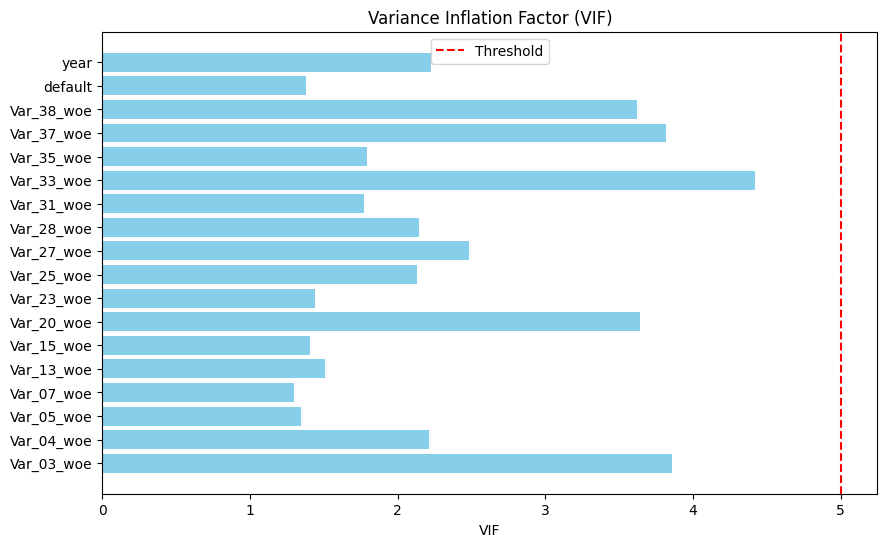

In [126]:
df_VIF_woe = check_collinearity(df_woe)

In [127]:
results_vif = train_and_evaluate_pipeline(df_VIF_woe)


KeyboardInterrupt: 